### Dependency

In [2]:
import pickle
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torch

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### load claims and zip2fips

In [3]:
data_path = r"D:\OneDrive - University of Edinburgh\paper\Spatio-temporal RSV\TAP-RSV 2\RSV\data"
#../data/claim.csv
disease_data = pd.read_csv(os.path.join(data_path,"claim.csv"))
# zip2fips = json.load(open("zip2fips.json", 'r'))
zip2fips_data = pd.read_csv(os.path.join(data_path,"zip2fips.csv"))

In [4]:
zip2fips = {}
for k, v in tqdm(zip2fips_data[["zipcode", "FIPS"]].values):
    if v == v:
        zip2fips[int(k)] = int(v)

100%|██████████| 41877/41877 [00:00<00:00, 1729196.55it/s]


In [5]:
disease_data.head()

,Unnamed: 0,date,zip,n_visits,Adenovirus,Asthma,Bronchiolitis,COVID,Cold,Coronavirus,...,Hypoxia,Parainfluenza,RSV,Respiratory distress,Respiratory failure,Rhinitis,Rhinovirus,Status Asthmaticus,URI,Viral pneumonia
0,0,2017-12-30,631,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,2017-12-30,637,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
2,2,2017-12-30,656,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,3,2017-12-30,716,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,4,2017-12-30,717,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
disease_data.columns

Index(['Unnamed: 0', 'date', 'zip', 'n_visits', 'Adenovirus', 'Asthma',
       'Bronchiolitis', 'COVID', 'Cold', 'Coronavirus', 'Enterovirus', 'HMPV',
       'Hypoxemia', 'Hypoxia', 'Parainfluenza', 'RSV', 'Respiratory distress',
       'Respiratory failure', 'Rhinitis', 'Rhinovirus', 'Status Asthmaticus',
       'URI', 'Viral pneumonia'],
      dtype='object')

### get the (county, date, 19 diseases) b_mtx

In [7]:
disease_category = disease_data.columns[4:]
date_map = {item: idx for idx, item in enumerate(disease_data.date.unique())}
zip_map = {item: idx for idx, item in enumerate(disease_data.zip.unique())}
fips_concern = np.unique([zip2fips.get(zipcode, -1) for zipcode in list(zip_map.keys())]).tolist()
fips_concern.remove(-1)
fips_map = {item: idx for idx, item in enumerate(fips_concern)}

b_mtx = np.zeros((len(fips_map), len(date_map), len(disease_category)))
print (b_mtx.shape)

(3150, 1848, 19)


In [8]:
for line in tqdm(disease_data.values):
    tmp_fips = zip2fips.get(line[2], -1)
    if tmp_fips == -1: continue
    
    for j in range(len(disease_category)):
        b_mtx[fips_map[tmp_fips], date_map[line[1]], j] = line[4 + j]

100%|██████████| 12325169/12325169 [00:49<00:00, 248439.96it/s]


In [9]:
fips_standard = pickle.load(open(os.path.join(data_path, "fips.pkl"), "rb"))
county_tensor = pickle.load(open(os.path.join(data_path, "county.pkl"), "rb"))
feat_name_HOIST = pickle.load(open(os.path.join(data_path, "feat_name.pkl"), "rb"))

In [10]:
# static feature ranges (it is ok, non-overlap with our prediction window)
min(feat_name_HOIST['date']), max(feat_name_HOIST['date'])

('2020-08-01', '2022-05-01')

In [11]:
# get the intersection fips
fips_new_idx = []
int_fips_map = list(map(int, fips_map.keys()))

for idx, fips in enumerate(fips_standard):
    if fips in int_fips_map:
        fips_new_idx.append(int_fips_map.index(fips))
    else:
        fips_new_idx.append(0)
    
# the fips (dim 1) of this bron matchs with Junyi's 2334 fips
bron = b_mtx[fips_new_idx]
print (bron.shape)

# aggregate the date into weeks
bron = np.diff(np.concatenate([np.zeros((bron.shape[0], 1, bron.shape[2])), np.cumsum(bron, 1)], 1)[:, ::7], axis=1)
weeks = list(date_map.keys())[::7]


(2334, 1848, 19)


### final processed data

In [12]:
print (len(weeks))
print (bron.shape)

264
(2334, 264, 19)


### tensor factorization tool

In [15]:
def optimize(A, B, D, reg=1e-6):
    u = torch.linalg.solve(A + reg * D, B)
    return u

def initialize(T, R, device):
    return *[torch.rand(I, R).to(device) for I in T.shape], torch.eye(R).to(device)

def NTF_2d(T, A1, A2, D, iteration=200, reg=1e-3, verbose=True):
    interval = iteration // 10
    for i in range(iteration):
        tmp = A2.T@A2
#         A1 = optimize(A2.T@A2 + reg * torch.ones_like(tmp), torch.einsum('ij,jr->ri',T,A2), D).T
        A1 = optimize(tmp, torch.einsum('ij,jr->ri',T,A2), D).T
        A1 = torch.clip(A1, min=0)
        A1 -= A1.max(1)[0].reshape(-1, 1) * reg * (A1 == np.abs(A1)) * torch.ones_like(A1)
        A1 = torch.clip(A1, min=1e-8)
        A2 = optimize(A1.T@A1, torch.einsum('ij,ir->rj',T,A1), D).T
        A2 = torch.clip(A2, min=1e-8)
        
        scale1 = torch.pow(torch.pow(A1, 2).sum(0), 0.5)
        scale2 = torch.pow(torch.pow(A2, 2).sum(0), 0.5)
        scale = torch.pow((scale1 * scale2), 0.5)
        
        A1 = A1 / scale1.reshape(1, -1) * scale.reshape(1, -1)
        A2 = A2 / scale2.reshape(1, -1) * scale.reshape(1, -1)
        
        if verbose:
            if i % interval == interval - 1:
                rec = torch.einsum('ir,jr->ij',A1,A2)
                loss = (torch.norm(rec - T) / torch.norm(T))**2
                print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        result = [item.cpu().numpy() for item in [A1, A2]]
    return result

In [16]:
np.random.seed(100)
R = 3

# only use the RSV part, scaled by pediatric population
rate = bron[:, :, 11] / county_tensor[:, 1].reshape(-1, 1)
rate_ = torch.Tensor(rate)
result = NTF_2d(rate_, *initialize(rate_, R=R, device='cpu'), reg=1e-1, iteration=100)

9/100 fitness loss: 0.4958789646625519
19/100 fitness loss: 0.49593353271484375
29/100 fitness loss: 0.49592405557632446
39/100 fitness loss: 0.4959215223789215
49/100 fitness loss: 0.4959210157394409
59/100 fitness loss: 0.4959208369255066
69/100 fitness loss: 0.4959207773208618
79/100 fitness loss: 0.4959207773208618
89/100 fitness loss: 0.49592068791389465
99/100 fitness loss: 0.4959207773208618


In [17]:
# this one is just used to change the color order
result[1] = np.array(result[1])[:, [0, 2, 1]]

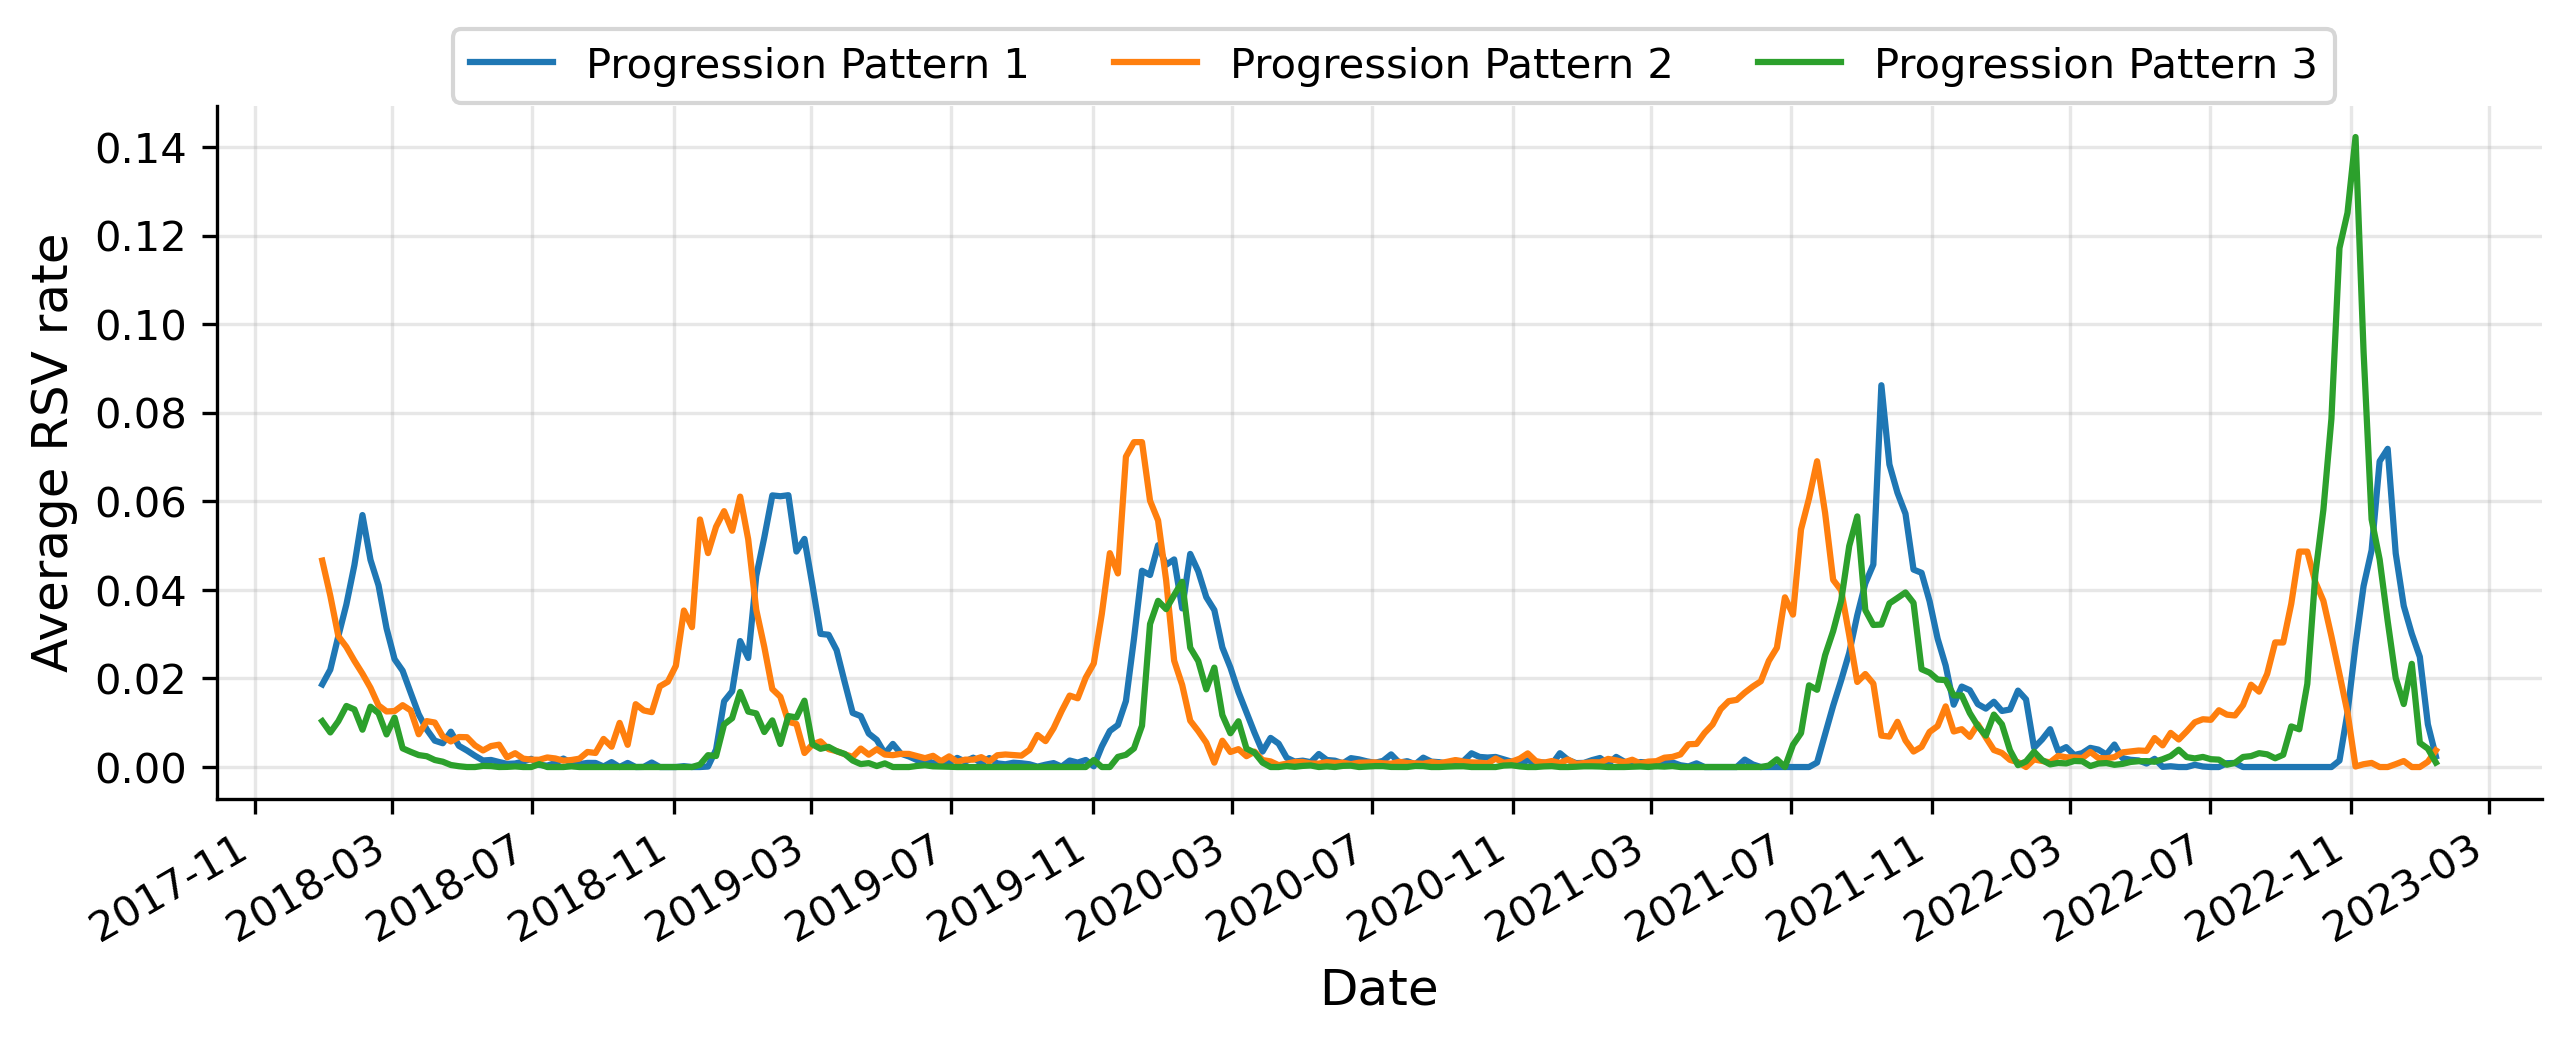

In [29]:
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
all_date = [item for item in list(date_map.keys())[::7]]
x_date = [datetime.strptime(d[:10],'%Y-%m-%d').date() for d in all_date]
for i in range(R):
    plt.plot(x_date, result[1][:, i], label=f"Progression Pattern {i+1}")

myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right', fontsize=10)
# plt.ylim([-0.5, 5.8])
plt.ylabel("Average RSV rate", fontsize=12)
plt.xlabel("Date", fontsize=12)
ax.grid(alpha=.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(ncols=3, bbox_to_anchor=(0.92,1.14))
plt.savefig("../fig/iqvia_hos_rate.png", bbox_inches='tight', dpi=300)

#plt.xticks(np.arange(len(all_date))[::10], all_date[::10], rotation=30, ha="right")
# plt.ylabel("average RSV rate")
# plt.legend(ncols=3)

### dump location embedding for prediction

In [61]:
# normalize the patterns and let each disease sum up to 1
county_tensor_emb = result[0] / result[0].sum(1).reshape(-1, 1)
pickle.dump(county_tensor_emb, open("../data/county_tensor_emb.pkl", "wb"))